In [1]:
from finance_utils.electrical.china.spot.discrete.probabilistic_forecast import DiscreteSpot, ProbabilisticDiscreteCurve, SpotNoise
from finance_utils.electrical.china.spot.discrete.testback import TestBack
from finance_utils.electrical.china.spot.rule.recycle import SampleRecycle
import numpy
from data_utils.stochastic_utils.distributions.baseclass import ABCDistribution
from data_utils.stochastic_utils.distributions.basic_distributions import NormalDistribution
from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist, LogHisDist
from data_utils.stochastic_utils.distributions.discrete.basic import DiscreteDistribution
from matplotlib import pyplot
import tqdm

In [2]:
quantity_min = 0
quantity_max = 30
submitted_min = 0
submitted_max = 30
trigger_rate = 0.09
punishment_rate = 0.5
random_p = 0.5

In [3]:
dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 20),
    NormalDistribution(201, 21),
    NormalDistribution(203, 22),
    NormalDistribution(102, 53),
])

realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.2, 20 * 1.5),
    NormalDistribution(201 * 0.9, 21 * 1.2),
    NormalDistribution(203 * 1.1, 22 * 1.3),
    NormalDistribution(102 * 0.8, 53 * 1.1),
])

quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5),
    NormalDistribution(9, 3),
    NormalDistribution(15, 1),
    NormalDistribution(25, 2),
], domain_min=quantity_min, domain_max=quantity_max)

spot = DiscreteSpot(dayahead, realtime, quantity)

# noise_dayahead = ProbabilisticDiscreteCurve([
#     NormalDistribution(200, 9 * 1.5),
#     NormalDistribution(201, 8 * 1.5),
#     NormalDistribution(203, 7 * 1.5),
#     NormalDistribution(102, 6 * 1.5),
# ])
# 
# noise_realtime = ProbabilisticDiscreteCurve([
#     NormalDistribution(200 * 1.2, 20 * 1.5),
#     NormalDistribution(201 * 1.1, 21 * 1.5),
#     NormalDistribution(203 * 1.2, 22 * 1.5),
#     NormalDistribution(102 * 0.8, 53 * 1.5),
# ])
# 
# noise_quantity = ProbabilisticDiscreteCurve([
#     NormalDistribution(10, 5 * 1.5),
#     NormalDistribution(9, 3 * 1.5),
#     NormalDistribution(15, 1 * 1.5),
#     NormalDistribution(25, 2 * 1.5),
# ], domain_min=quantity_min, domain_max=quantity_max)
# noise_spot = DiscreteSpot(dayahead, realtime, quantity)

In [4]:
train_testback = TestBack(spot.diff_random_sample(p=random_p, epoch=100, n=100))
submitted_quantity = train_testback.differential_evolution__search(
    quantity.value_list, 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)
control_group_quantity = quantity.value_list

100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


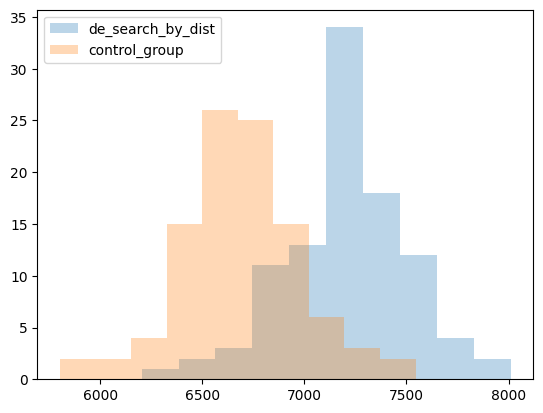

In [5]:
ylist = []
for _ in tqdm.trange(100):
    test_testback = TestBack(spot.diff_random_sample(p=random_p, epoch=100, n=100))
    s = test_testback.testback_yield(submitted_quantity[0], trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean()
    c = test_testback.testback_yield(control_group_quantity, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean()
    ylist.append([s, c])
yarray = numpy.array(ylist).astype(float)
pyplot.hist(yarray[:,0], alpha=0.3)
pyplot.hist(yarray[:,1], alpha=0.3)
pyplot.legend(["de_search_by_dist", "control_group"])
pyplot.show()

In [6]:
print(spot.value_list_yield(
    spot.quantity.value_list, 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
))
print(
    spot.value_list_yield(
        submitted_quantity[0], 
        submitted_min=submitted_min,
        submitted_max=submitted_max,
        trigger_rate=trigger_rate, 
        punishment_rate=punishment_rate
    )
)

print(numpy.mean(yarray[:,1]))
print(numpy.mean(yarray[:,0]))

9404.0
10121.11100076486
6680.741604868715
7207.769985943413


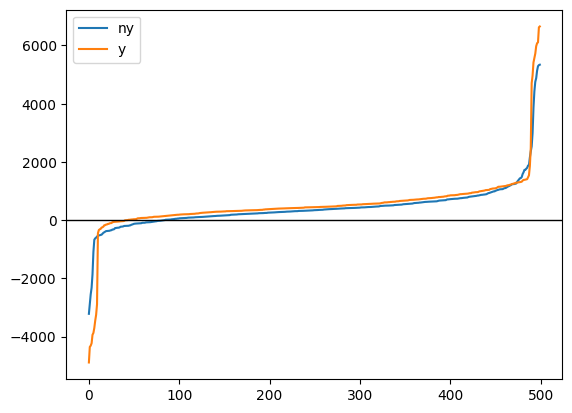

noised:6178.662202273491
noised_control:5748.25588369
y:7141.961270259168
control:6619.691084535069


In [9]:
noise = SpotNoise(
    [NormalDistribution(-50, 20)] * 4,
    [NormalDistribution(50, 30)] * 4,
    [NormalDistribution(5, 5)] * 4,
)
# noised_testback = TestBack(spot.diff_random_sample(p=0.3, epoch=100, n=100)).add_noise(noise)
# test_testback = TestBack(spot.diff_random_sample(p=0.3, epoch=100, n=100))

random_sample = spot.diff_random_sample(p=random_p, epoch=500, n=100)
test_testback = TestBack(random_sample)
noised_testback = TestBack(spot.noised_random_sample(random_sample, noise))
y = test_testback.testback_yield(
    submitted_quantity[0],
    trigger_rate=trigger_rate, punishment_rate=punishment_rate
)

cy = test_testback.testback_yield(
    spot.quantity.value_list,
    trigger_rate=trigger_rate, punishment_rate=punishment_rate
)


ny = noised_testback.testback_yield(
    submitted_quantity[0], 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)

ncy = noised_testback.testback_yield(
    spot.quantity.value_list, 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)
pyplot.plot(numpy.sort(ny.yield_curve - ncy.yield_curve))
pyplot.plot(numpy.sort(y.yield_curve - cy.yield_curve))
pyplot.axhline(0, color='black', linewidth=1)
pyplot.legend(["ny", "y"])
pyplot.show()
print(f"noised:{ny.mean()}")
print(f"noised_control:{ncy.mean()}")
print(f"y:{y.mean()}")
print(f"control:{cy.mean()}")

0.1734935768854886
0.08716263523558751


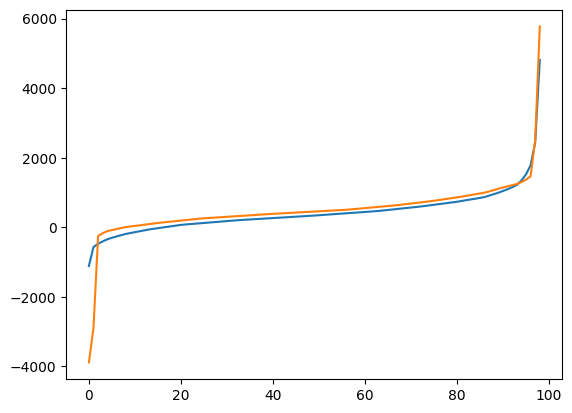

In [10]:
noised_diff_dist = HistogramDist(ny.yield_curve - ncy.yield_curve)
diff_dist = HistogramDist(y.yield_curve - cy.yield_curve)

pyplot.plot(noised_diff_dist.cdf().x)
pyplot.plot(diff_dist.cdf().x)

print(noised_diff_dist.cdf(0))
print(diff_dist.cdf(0))